In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

# Tercera parte mejorando la lectura mediante el font

In [2]:
import pandas as pd
import cv2
import numpy as np
from pipeline_img_ver2 import PipelineImg
import pytesseract
import json
from pytesseract import Output


pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', False)

# Cargando datos para generaar fuente actual

In [3]:
import cv2
from matplotlib import pyplot as plt

In [4]:
df_output = pd.read_pickle("text/ficheros_ocr_data.pkcl")

In [5]:
imgs_paths = list(df_output["path"])

In [6]:
df_output.shape

(18008, 4)

In [7]:
df_output.head(1)

path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Algoritmo para obtener el font relativo de todas las imagenes

In [8]:
import numpy as np
import os
# Para correr en hilos la evaluación este parametro aumenta significativamente la velocidad de evaluacion
os.environ['OMP_THREAD_LIMIT'] = '1'

In [9]:
import re

def get_font_size(ocr_data):
    # Remove outlayers
    reject_outliers = lambda data: data[abs(data - np.mean(data)) < 2 * np.std(data)] if data.shape[0] > 1 else data
    # Getting only good predictions
    return (np.mean(reject_outliers(ocr_data[(ocr_data["conf"].astype(int) >70) & (ocr_data["text"].apply(lambda txt: re.search("[A-Za-z0-9]",txt) is None) == False )]["height"].fillna(0.0).astype("int"))))

In [10]:
%%time
df_output["font_size_estimated"] = df_output["ocr_data"].apply(lambda text_data: get_font_size(pd.DataFrame(json.loads(text_data)))
)

CPU times: user 59.4 s, sys: 0 ns, total: 59.4 s
Wall time: 60 s


In [11]:
configs = [{"h":1728, "w":2304, "sigma":0.33, "pixels":1200, "border":15},
{"h":2432, "w":4320, "sigma":0.01, "pixels":900, "border":20},
{"h":3456, "w":4608, "sigma":0.01, "pixels":1300, "border":25},
{"h":2304, "w":1728, "sigma":0.33, "pixels":1300, "border":20},
{"h":1944, "w":2592, "sigma":0.33, "pixels":1300, "border":15},
{"h":4608, "w":3456, "sigma":0.33, "pixels":1200, "border":15},
{"h":3264, "w":2448, "sigma":0.33, "pixels":1300, "border":20},
{"h":2448, "w":3264, "sigma":0.33, "pixels":1200, "border":20}]
def get_nearest_conf(shape):
    return min(configs,key=lambda cnf: np.sqrt(((cnf["h"]-shape[0])**2)+((cnf["w"]-shape[1])**2)))

In [12]:
df_output.head()

path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [13]:
df_output[["path","font_size_estimated", "resize_shape", "cutted_area"]].columns

Index(['path', 'font_size_estimated', 'resize_shape', 'cutted_area'], dtype='object')

In [8]:
from pipeline_img_ver2 import PipelineImg
import re

def get_font_size(ocr_data):
    # Remove outlayers
    reject_outliers = lambda data: data[abs(data - np.mean(data)) < 2 * np.std(data)] if data.shape[0] > 1 else data
    # Getting only good predictions
    return (np.mean(reject_outliers(ocr_data[(ocr_data["conf"].astype(int) >70) & (ocr_data["text"].apply(lambda txt: re.search("[A-Za-z0-9]",txt) is None) == False )]["height"].fillna(0.0).astype("int"))))


def eval_img_with_setting_font(params):
    
    path = params[0]
    font_size = params[1]
    resize_shape = params[2]
    
    try:
        img = cv2.imread(path)
        if(img.shape[0]>img.shape[1]):
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)


        new_h = int(np.ceil(img.shape[0]-(1/(42/font_size))*(img.shape[0]-resize_shape[0])))


        conf = get_nearest_conf(img.shape)

        pre_img, res_shape, cuted_area = PipelineImg.do_full_pipeline(img, height=new_h,bordersize=conf["border"] ,auto_canny_sigma= conf["sigma"], debug=False)
        config=None

        if img.shape[0]> img.shape[1]:
            config = ("-l spa --psm 1")
        else:
            config = ("-l spa --psm 6 ")
        text_data = json.dumps(pytesseract.image_to_data(pre_img, config=config, output_type=Output.DICT))
        print("-", end="")

        return (path, text_data, res_shape[:2], cuted_area)
    except:
        return (path,None,None,None)


In [15]:
%%time
import multiprocessing as mp
print("Procesando con {} nucleos".format(mp.cpu_count()))
pool = mp.Pool(mp.cpu_count())
results = pool.map(eval_img_with_setting_font, df_output[~df_output["font_size_estimated"].isnull()][["path","font_size_estimated", "resize_shape"]].to_numpy())
pool.close()

Procesando con 8 nucleos


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
%%time
df_output = pd.DataFrame(results, columns=["path","ocr_data", "resize_shape", "cutted_area"])
#df_output.to_pickle("text/ficheros_font_regularized.pkcl")

CPU times: user 60.4 ms, sys: 408 ms, total: 469 ms
Wall time: 493 ms


In [4]:
df_output = pd.read_pickle("text/ficheros_font_regularized.pkcl")

In [10]:
import re

def get_font_size(ocr_data):
    # Remove outlayers
    reject_outliers = lambda data: data[abs(data - np.mean(data)) < 2 * np.std(data)] if data.shape[0] > 1 else data
    # Getting only good predictions
    return (np.mean(reject_outliers(ocr_data[(ocr_data["conf"].astype(int) >70) & (ocr_data["text"].apply(lambda txt: re.search("[A-Za-z0-9]",txt) is None) == False )]["height"].fillna(0.0).astype("int"))))
def get_exps(ocr_data):

    match_regx5 = "((\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3}))"
    match_regx4 = "((\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3}))"
    match_regx3 = "((\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3}))"
    find_null = lambda el: el[0] if el != None else None
    ocr_data["exp_5_numeric"] = ocr_data["text"].apply(lambda elm: re.search(match_regx5, elm)).apply(find_null)
    ocr_data["exp_4_numeric"] = ocr_data["text"].apply(lambda elm: re.search(match_regx4, elm)).apply(find_null)
    ocr_data["exp_3_numeric"] = ocr_data["text"].apply(lambda elm: re.search(match_regx3, elm)).apply(find_null)
    return np.sum(np.where((~ocr_data["exp_5_numeric"].isnull() )|(~ocr_data["exp_4_numeric"].isnull() ) | (~ocr_data["exp_3_numeric"].isnull() ),1,0))
    

In [21]:
%%time
df_output["font_size_estimated"] = df_output["ocr_data"].apply(lambda text_data: get_font_size(pd.DataFrame(json.loads(text_data))
                                                                                              ) if text_data is not None else None
)
df_output["exps"] = df_output["ocr_data"].apply(lambda text_data: get_exps(pd.DataFrame(json.loads(text_data))
                                                                                              ) if text_data is not None else None)


CPU times: user 2min 49s, sys: 3.53 ms, total: 2min 49s
Wall time: 2min 49s


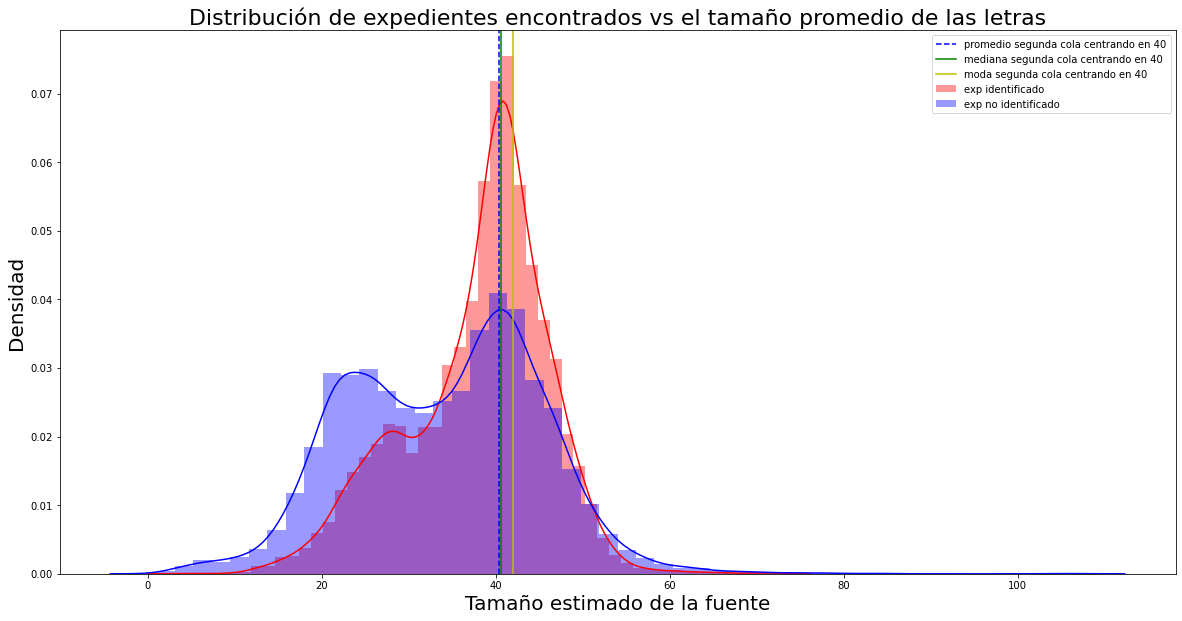

Moda:42.0 	 Promedio:40.397421268907614 	 Mediana:40.61538461538461 


In [22]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df_output[df_output["exps"]>0]["font_size_estimated"],color="red", ax=ax, label="exp identificado")
sns.distplot(df_output[df_output["exps"]==0]["font_size_estimated"],color="blue", ax=ax, label="exp no identificado")

mean=df_output[(df_output["exps"]>0) & (df_output["font_size_estimated"].between(30,50))]["font_size_estimated"].mean()
median=df_output[(df_output["exps"]>0) & (df_output["font_size_estimated"].between(30,50))]["font_size_estimated"].median()
mode= df_output[(df_output["exps"]>0) & (df_output["font_size_estimated"].between(30,50))]["font_size_estimated"].mode()[0]

ax.axvline(mean, color='b', linestyle='--', label= "promedio segunda cola centrando en 40")
ax.axvline(median, color='g', linestyle='-', label="mediana segunda cola centrando en 40")
ax.axvline(mode, color='y', linestyle='-', label="moda segunda cola centrando en 40")
ax.set_xlabel("Tamaño estimado de la fuente", fontsize=20)
ax.set_ylabel("Densidad", fontsize=20)
plt.title("Distribución de expedientes encontrados vs el tamaño promedio de las letras", fontsize=22)
plt.legend()

plt.show()
print("Moda:{} \t Promedio:{} \t Mediana:{} ".format(mode, mean, median)) 

In [25]:
df_output[df_output["exps"] != 0].shape

(8683, 6)

In [134]:
df_output[df_output["font_size_estimated"] >=75 ].shape

(25, 6)

In [ ]:
df_output[df_output["font_size_estimated"]<5].shape

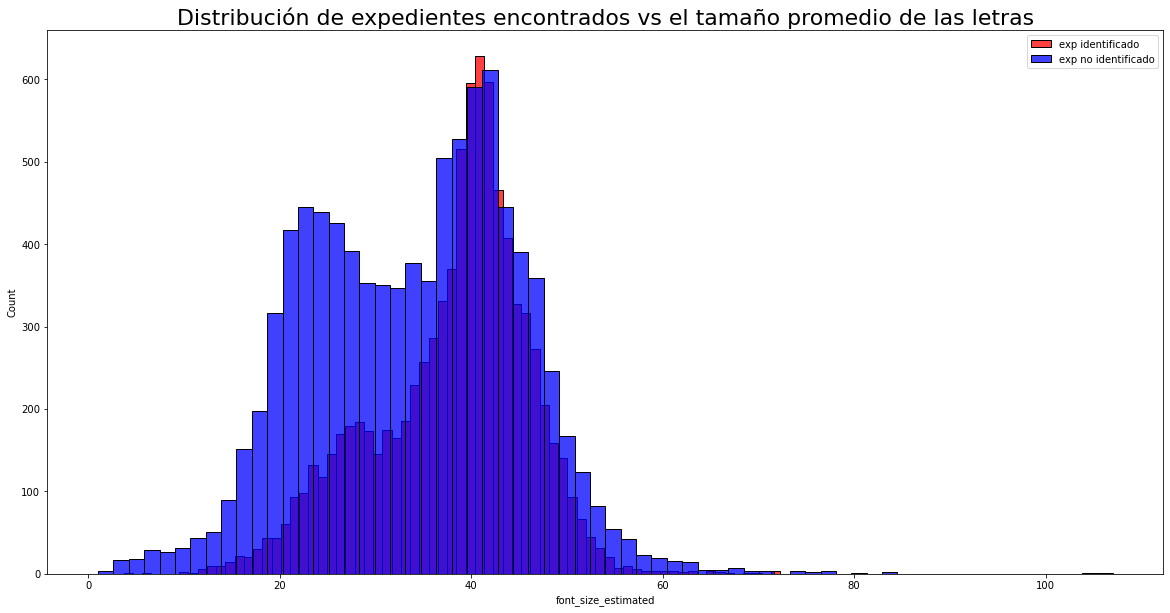

In [26]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(df_output[df_output["exps"]>0]["font_size_estimated"],color="red", ax=ax, label="exp identificado")
sns.histplot(df_output[df_output["exps"]==0]["font_size_estimated"],color="blue", ax=ax, label="exp no identificado")
plt.title("Distribución de expedientes encontrados vs el tamaño promedio de las letras", fontsize=22)
plt.legend()

plt.show()

In [59]:
a.ax

AttributeError: 'Figure' object has no attribute 'ax'

In [33]:
get_font_size(ocr_data)

42.922077922077925

In [171]:
ocr_data[~ocr_data["exp_3_numeric"].isnull()]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,exp_5_numeric,exp_4_numeric,exp_3_numeric
38,5,1,1,1,3,4,968,233,477,56,27,Exp.11=136-965.,None,None,11=136-965
80,5,1,1,1,7,5,976,516,525,72,52,Exp.11-136-968.,None,None,11-136-968
116,5,1,1,1,11,8,1114,724,518,49,42,Expe100-20-16-2-71,100-20-16-2-71,100-20-16-2,100-20-16


In [158]:
" ".join(ocr_data["text"])

'    \' m Í\';*X;ÍExp;“llél36=68 -  D a N H-60 L-19- —  - | o6-Ene-68.- El 24 actual "“El Universal" publicó:  — | fota "ADIESTRAN COMUNISTAS EN ATOYAC"-en-el,que -  \' | se. involucfa a este elemento,- La CCI de “Garzón.  - - + dice 633conocer\'cualquíer\'relación\'de este elemel   to con miembros del PCI, pues no tienen ligas col  — | dicho Partido, y que de ser verdad lo dicho en -  - |el periódico, se dfstítuíraligfediatamente,de*su  — ¡“actual puesto a e3uepelemengo.e Exp.11-136-68. -  o - H-9  L-19.. —  () —| 9-Feb-68.- Se envió un boletín a difermntes dia-  — —| rios capitalinos: intitulado "SAMUEL ADAME\'FLORES  — + Repte. de la CCI., en el Edo, de Gro., "Ajeno to  - .E talmente en actos de agitación".-Se dice que al-  = . | comprobar esta Central su inocencia en los cargo'

In [140]:
i|ddnt(78/h_ratio)

159

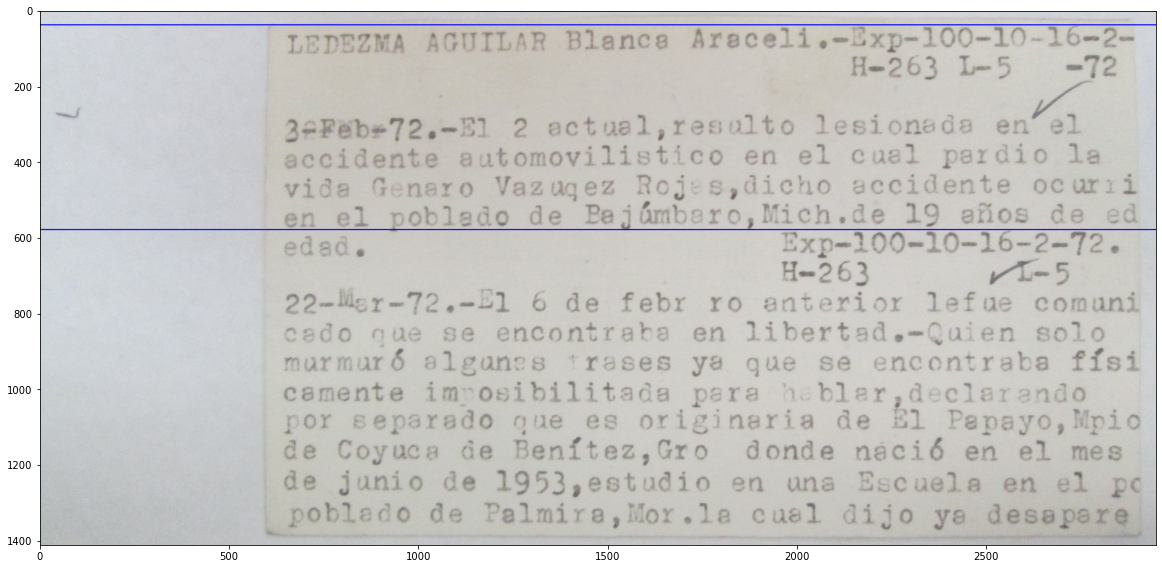

In [152]:
line_img = img[new_x1:new_x2,new_y1:new_y2]
for top in ocr_data[~ocr_data["exp_3_numeric"].isnull()]["top"]:
    line_img = cv2.line( line_img, (0, int(top/h_ratio)), (line_img.shape[1], int(top/h_ratio)), (255, 0, 0), thickness=2)
    print("Parte {}"%top)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))

In [129]:
ocr_data[~ocr_data["exp_3_numeric"].isnull()]["top"]

8     18 
79    283
Name: top, dtype: int64

In [109]:
for lvl in range(1,32):
    print(" ".join(ocr_data[ocr_data["line_num"] == lvl]["text"]).strip())
    print("\n")

C AGUILAR - MARTINEZ, Blanca Araceli Ex-5 16-1-972. '  FOLIO 95.—Se sobresec el presente. juicio de earantiaá. .


f ! F — H 489 Ly227. *


5 Feb.72º=Amparo'Nd.57/72. El Lic. JOSE ROJO CO


' RONADO 1, - nombro ' de MARIA AGUILA?¡' MARTINEZ y. BLAN


CA ARAC%LI AGUILAR MARTINEZ :6 BLANCA" HRACELT LE:


-DESMA AGUILAR solicito. amparo contra actos de ls


-D.P.S.. y otras autoridades ante el Juez 20.Dto.;


rdel D.F. en E.Penal - quien solicito los informes


cprevio y justificodo los cueles fueron rendidos:


“ por la D.P.S. el 4 actual negando los cargos. í


2 - Exp—5—16—1—7%


¿23—fob—72.—"1 18 aot. el Juéz 2/0.de Dto!.izgí D%;?.225.“a-º


“£oría Penal, negó la vuspensión defitiniva de los u<;'.oa—i


: que esta. persona reclama.-—-—-——-'-—-—…_—-—-——__—…-——-_¡























































In [68]:
ocr_data

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1732,1163,-1,
1,2,1,1,0,0,0,7,242,1725,860,-1,
2,3,1,1,1,0,0,7,242,1725,860,-1,
3,4,1,1,1,1,0,33,242,1699,90,-1,
4,5,1,1,1,1,1,33,266,2,2,85,'
...,...,...,...,...,...,...,...,...,...,...,...,...
150,5,1,1,1,16,7,949,1043,69,63,92,su
151,5,1,1,1,16,8,1051,1044,276,49,92,inocencia
152,5,1,1,1,16,9,1363,1052,59,28,73,en
153,5,1,1,1,16,10,1452,1041,90,37,92,los


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('segunda_fase').getOrCreate()
#salida_dataframe.write.parquet("text/archivos")

In [10]:
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, ArrayType
schema = StructType([
    StructField("path", StringType()), 
    StructField("ocr_data", StringType()), 
    StructField("resize_data", ArrayType(IntegerType())), 
    StructField("cut_data", ArrayType(IntegerType())), 
    
])
df_2 = spark.createDataFrame(results, schema=schema)

In [12]:
df_2.write.mode("overwrite").parquet("text/archivos_ocr_data")

Py4JJavaError: An error occurred while calling o45.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:226)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:178)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:122)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:121)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:963)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:764)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:963)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:399)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:288)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:848)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Job 1 cancelled 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1955)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2205)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:195)
	... 33 more


) ae i> | = . {> t C nc ? ar Yr

26-Abrile71l.<Con motivo de 1 A bedee os ny Asbo ee

licia del Sd: ee Gro.,de FRANCISCO GARAY «a TZd
po | ~ we © ey 2 iat m~nMat rena S¢ 37 la oo 5e ler ent
8 on Sus qa-=ciar: LONeS aLG@ @ @&St ilo
eomo uno de los in egrantes de la guerrilla de.

4
oe

G5 TARC TAZQT ‘ Z, RC JA S ® ~ uy pel () QO-1O a1 6 yaw D - 71 2

26-Abril-71.- H- 372 Lo
SUPLICIC DE J&sSuS DE

de octubre del197

individuos extrafio

les exhortaban a 1

a2lecausa de quit:

10S pobres,=

fi GUL serial d que en el mesg
e@ ler ‘ento lievé a varios.

Mpicede Se ntiago,los cua
poli asnres a Que se unierer
4a 10S ricos pere darile &

oo
lor?
es)
O'S Hct it

 



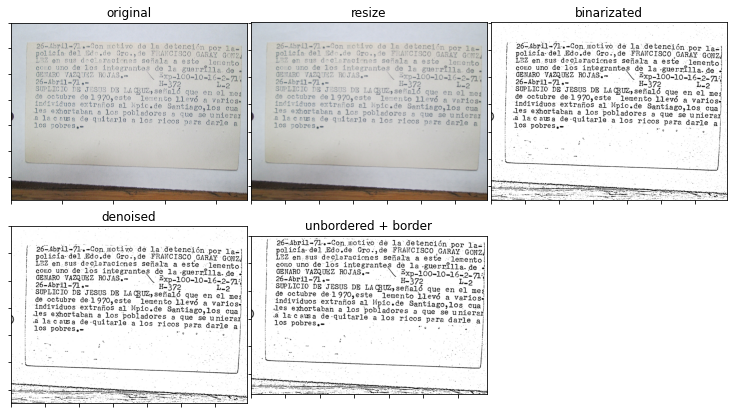

In [50]:
from pytesseract import Output

img = cv2.imread(imgs_paths[1])
conf = get_nearest_conf(img.shape)
pre_img, res_shape, cuted_area = PipelineImg.do_full_pipeline(img, height=conf["pixels"],bordersize=conf["border"] ,auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 6 ")
dtext = pytesseract.image_to_data(img, output_type=Output.DICT)
print(pytesseract.image_to_string(img))

In [7]:
conf["pixels"]

1300

In [8]:
cuted_area

(0, 1160, 0, 1732)

In [9]:
res_shape

(1300, 1733, 3)

; ; '
# perros - cy eo ames #1 ree ee aes 3 } “. : te Eid
BE Pnoe65.=— Bl 24 actual
acu

now re i" AD ae st LIN bi Bat LV he Med he Y snens Bet oe
se involucta a este el
Se Ln ke ti EK i | et Naat taut f ’us B

ma ® —

dice desconocer cualquier
* oo, See 4 ,

con miembros

pm

wee ae
t 8, ud l

(D
ee
4
a a
tid
~~.
~~

» OL

wf 2 ; pee : -
G@icho Partido, y que de :
| ? “ - “| auin a ase 8 wy
el perloacico, eo festiitulre
i a
' -

: ees en dé
actual puesto

 

:

~ Exp, 11+136-68

1 Universal" publicé
EN ATOYAC™ en el que
mentoe- La CCI de Garzbn
relaci6bn de este eleme}
as no tienen Ligas co)

ee se
Veraa
* e

inmediatamente de su

9 este elemento — EXD - 11-136-68,.

H-96 L-19.

9-Teb-68,- Se envio un boletin a diferantes dla-
rios capitalinos intitulado

"SAMUEL ADAME FLORES

Repte. de la CCI., en el Edo. de areas Aisne
ce que al-

talmente en actos de agitacion".-Se d
comprobar esta Central su inocencia en los ¢

  

   



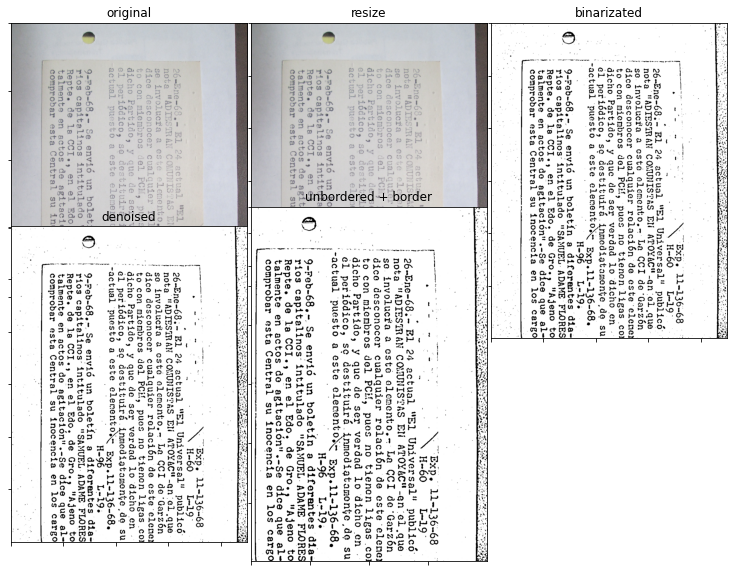

In [80]:
from pytesseract import Output

img = cv2.imread(imgs_paths[3])
#img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
conf = get_nearest_conf(img.shape)

pre_img = PipelineImg.do_full_pipeline(img, height=conf["pixels"],bordersize=conf["border"] ,auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 5 ")
dtext = pytesseract.image_to_data(img, output_type=Output.DICT)
print(pytesseract.image_to_string(img))

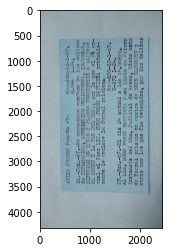

In [69]:
from matplotlib import pyplot as plt
plt.imshow(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))

In [27]:
df = pd.DataFrame(dtext)

In [58]:
df[~df["exp_4_numeric"].isnull()].head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,exp_5_numeric,exp_4_numeric,exp_3_numeric
25,5,1,5,1,1,5,2613,382,993,260,0,Bxpe100=10-1-676,None,100=10-1-676,100=10-1
85,5,1,5,2,1,2,2852,1255,813,169,0,5=100=10-1=67~,5=100=10-1=67,5=100=10-1,5=100=10


In [32]:
" ".join(df["text"]).stri

'an aoaee    AVILA JUAREZ Fausto -7- Bxpe100=10-1-676 ,  26. ~Juh.~67«-Be encuentra comfeso de los delites  ~\' de DIFAMACION, ASO@EGCION DELICTUOSA, INJUREAS,  "* DIFUSION DE IDEAS Y PLANES TENDIENTES A ALTERAR  EL ORDEN Y LA PAZ DEL EDO., por lo que el 2% ace  tual el Juez LIC. HUGO PEREZ BAUTISPA probable=—  mente ile declare la formal prisions   Ex 5=100=10-1=67~ |   H=271 Le2h,  27 .~JUNe-67e-El dia 24 actual a las 14,.00Hrs,  el Lic. HUGO PEREZ BAUTISTA Jusz Mixto de Primer  Instancia del Dto, Judicial de Bravo, Dicto atito  de Formal prisjon en contra de ESTE ELEMENTO>  "otros con los que fue detenidos, por los deli'

In [59]:
df.iloc[23:28]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,exp_5_numeric,exp_4_numeric,exp_3_numeric
84,5,1,5,2,1,1,2709,1321,130,74,96,Ex,None,None,None
85,5,1,5,2,1,2,2852,1255,813,169,0,5=100=10-1=67~,5=100=10-1=67,5=100=10-1,5=100=10
86,5,1,5,2,1,3,3751,1388,5,36,43,|,None,None,None


In [60]:
df.iloc[23:28]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,exp_5_numeric,exp_4_numeric,exp_3_numeric
23,5,1,5,1,1,3,1634,503,369,119,9,Fausto,None,None,None
24,5,1,5,1,1,4,2062,507,182,71,85,-7-,None,None,None
25,5,1,5,1,1,5,2613,382,993,260,0,Bxpe100=10-1-676,None,100=10-1-676,100=10-1
26,5,1,5,1,1,6,3689,536,54,27,0,",",None,None,None
27,4,1,5,1,2,0,877,652,2865,155,-1,,None,None,None


In [61]:
df[df["text"].strip() == ""]

AttributeError: 'Series' object has no attribute 'strip'

In [ ]:
"((\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3}))"

In [33]:
import re

In [50]:
x = re.search("((\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3}))", "12-12-11-22-12jsdiaojdoiaosda")

In [51]:
x[0] if x != None else None

'12-12-11-22-12'

In [13]:
IMG_SHAPES_DF = pd.read_csv("data/img_features.csv")

array([['/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6837.JPG',
        1],
       ['/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6838.JPG',
        1],
       ['/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6839.JPG',
        1],
       ...,
       ['/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-97-.JPG',
        0],
       ['/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-98-.JPG',
        1],
       ['/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-99-.JPG',
        0]], dtype=object)

In [72]:
IMG_SHAPES_DF[IMG_SHAPES_DF["h"]>IMG_SHAPES_DF["w"]]

,path,h,w,c,is_horizontal
3,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6840.JPG,4608,3456,3,0
67,"/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Aviles_Rojas_Epifanio,_fichas/Aviles_Rojas_Epifanio,_fichas-2-.JPG",4608,3456,3,0
69,"/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Aviles_Rojas_Epifanio,_fichas/Aviles_Rojas_Epifanio,_fichas-4-.JPG",4608,3456,3,0
71,"/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Aviles_Rojas_Epifanio,_fichas/Aviles_Rojas_Epifanio,_fichas-6-.JPG",4608,3456,3,0
87,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Bracho_Campos_Ismael/IMG_6923.JPG,4608,3456,3,0
...,...,...,...,...,...
17994,"/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-87-.JPG",4608,3456,3,0
17999,"/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-91-.JPG",4608,3456,3,0
18001,"/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-93-.JPG",4608,3456,3,0
18005,"/media/juan/jc/archivos_represion/Ficheros/Zona_Militar_27,_fichas/Zona_Militar_27,_fichas-97-.JPG",4608,3456,3,0


In [18]:
results

[('/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6837.JPG',
  '{"level": [1, 2, 3, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5], "page_num": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
df_2 = spark.createDataFrame(results,)

In [21]:
df_2.show()

+--------------------+--------------------+------------+--------------------+
|                  _1|                  _2|          _3|                  _4|
+--------------------+--------------------+------------+--------------------+
|/media/juan/jc/ar...|{"level": [1, 2, ...|[1300, 1733]|  [0, 1299, 0, 1732]|
|/media/juan/jc/ar...|{"level": [1, 2, ...|[1300, 1733]|[127, 1285, 0, 1732]|
|/media/juan/jc/ar...|{"level": [1, 2, ...|[1300, 1733]|  [0, 1299, 2, 1732]|
|/media/juan/jc/ar...|{"level": [1, 2, ...|[1300, 1733]|  [0, 1163, 0, 1732]|
|/media/juan/jc/ar...|{"level": [1, 2, ...|[1300, 1733]| [0, 1299, 66, 1732]|
+--------------------+--------------------+------------+--------------------+



In [20]:
pd.DataFrame(json.loads(df_2.select("_2").collect()[1]._2))

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1732,1158,-1,
1,2,1,1,0,0,0,0,15,1728,676,-1,
2,3,1,1,1,0,0,0,15,1718,139,-1,
3,4,1,1,1,1,0,77,15,1611,75,-1,
4,5,1,1,1,1,1,77,22,46,39,62,+
...,...,...,...,...,...,...,...,...,...,...,...,...
124,5,1,1,7,5,5,1106,633,3,2,9,:
125,5,1,1,7,5,6,1212,650,54,28,54,e
126,5,1,1,7,5,7,1505,637,124,50,54,TO
127,5,1,1,7,5,8,1671,636,7,55,65,!


In [97]:
import json


In [102]:
df_2.show()

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|/media/juan/jc/ar...|"level\tpage_num\...|
|/media/juan/jc/ar...|"level\tpage_num\...|
|/media/juan/jc/ar...|"level\tpage_num\...|
|/media/juan/jc/ar...|"level\tpage_num\...|
|/media/juan/jc/ar...|"level\tpage_num\...|
+--------------------+--------------------+



In [ ]:
element = 

In [ ]:
match_regx5 = "((\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3}))"
match_regx4 = "((\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3}))"
match_regx3 = "((\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3}))"
find_null = lambda el: el[0] if el != None else None
df["exp_5_numeric"] = df["text"].apply(lambda elm: re.search(match_regx5, elm)).apply(find_null)
df["exp_4_numeric"] = df["text"].apply(lambda elm: re.search(match_regx4, elm)).apply(find_null)
df["exp_3_numeric"] = df["text"].apply(lambda elm: re.search(match_regx3, elm)).apply(find_null)